# Events Table Stratified

__Description__: 
A stratified sampling of runoff events is performed on a runoff distribution derived from 
- Rainfall distribution based on the NOAA Atlas 14 (or mean precipitation curve) data (area averaged) and
- Max. potential retention distribution based on a beta distribution.

The rainfall distribution is assumed to be represented by a generalized extreme value distribution (GEV). This GEV distribution is fitted to the data (NOAA Atlas 14 data or corresponding values for the mean precipitation curve). The maximum potential distribution variabilitity corresponds to the curve number (CN) dispersion documented by the NRCS. For the rainfall distribution and runoff distribution, this notebook sequentially calculates 
- GEV distribution parameters for the NOAA or mean precipitation curve data
- Rainfall values and probability weights for different return period events
- Max potential retention variability and distribution parameters
- Partition for the max potential distribution for calculating the runoff distribution
- Runoff as a function of the return interval (i.e., return period)
- Runoff event probability weights
- A stratified sampling of runoff, where for each return interval the sampling includes
    - Event weight
    - Runoff value
    - Max. potential retention value
    - Rainfall value
    

__Input__: 
- Parameters: curve number and initial abstraction ratio; the probable maximum precipitation; return intervals for stratified sampling; maximum return interval limit for the stratified sampling bins;  the volume, region, and duration ([See map for volume and region](https://hdsc.nws.noaa.gov/hdsc/pfds/pfds_temporal.html)).
        
- The area averaged precipitation frequency data for the specified duration.

- `DataRepository` folder which contains the following:
    - The *NEH630_Table_10_1.json* which contains information about the spread of possible values around the provided (expected) curve number. [Source](https://www.wcc.nrcs.usda.gov/ftpref/wntsc/H&H/NEHhydrology/ch10.pdf).


__Output__: 1 JSON file with the Hydro 1-4 event hyetographs and 1 JSON file with event weights. Additionally 4 DSS files with the Hydro 1-4 hyetograph information is prepared. Intermediate csv and excel files are saved for reference.


---
## Load Libraries, Parameters, and Data:
### Libraries:

In [2]:
import sys
sys.path.append('../../core')
from hydromet import*
from hydromet_stratified import*
import hydromet_JSON_to_DSS
import mean_frequency_curve
%matplotlib inline

### Parameters: 
#### Local (site specific):

In [3]:
## Excess rainfall parameters:
CN  = 85  # Curve number, must be an integer
mu  = 0.2  # Intial abstraction ratio parameter
PMP = 32.10  # [inches]; Probable maximum precipitation for the selected duration 
Return_Intervals = np.array([2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000, 3000])  # Return intervals for calculating runoff values.
RI_upper_bound = 3700  # Upper Limit of recurrence interval evaluation, suggest not changing this value
lower_limit = 1 # Lower limit of NOAA Atlas 14 precipitation values
Aerial_Reduction = 1  # Aerial reduction factor
duration = 12  # [hours]; Event duration;  must be a duration in the input Precip_Table file
Time_Extend = 12.0 # Model run time extension beyond the hyetograph (24-hour) period.
hydrology_IDs = [1, 2, 3, 4]  # ID's of the different hydrology scenarios considered. 


## Mean curve parameters:
return_intervals_mc = np.array([1.01, 1.05, 1.11, 1.25, 20, 2000, 5000, 10000, 20000, 50000, 100000, 200000, 1/2E-06, 1/1E-06, 1/5E-07, 1/2E-07, 1/1E-07]) # Additional return intervals for the mean curve inputs
CL = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999]) # Confidence limits

## Integration parameter:
n_partition = 30  # Define number of partitions of max potential retention distribution; this controls the resolution of the integration of int p(Q|S)p(S) dS

## Filenames and paths:
Project_Area = 'JoCo'          # Project area name
Pluvial_Model = 'P01'                # Pluvial model name
BCN = 'TurkeyCreek'               # Domain/boundary condition name 071200040505 Kansas 102500170609 Nevada '160600140303'

precip_table = '{0}_{1}_{2}_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NOAA Data
precip_mean_curve_input_table = f'Mean_Curve_Input_{Project_Area}.csv'
precip_mean_curve_table = f'MeanCurve_{Project_Area}.csv'
CN_Distribution = 'NEH630_Table_10_1.json'
nrcs_precip_table = '{0}_{1}_{2}_nrcs_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # NRCS Data
atlas14_precip_table = '{0}_{1}_{2}_atlas_temporal_PrecipTable.xlsx'.format(Project_Area, Pluvial_Model, BCN)  # Atlas 14 Temporal Data

root_dir = pl.Path(os.getcwd())
outputs_dir = root_dir/'Outputs'
precip_table_dir = outputs_dir/precip_table
nrcs_precip_table_dir = outputs_dir/nrcs_precip_table   
atlas14_precip_table_dir = outputs_dir/atlas14_precip_table 
precip_mean_curve_input_table_dir = outputs_dir/precip_mean_curve_input_table
precip_mean_curve_table_dir = outputs_dir/precip_mean_curve_table
datarepository_dir = root_dir.parent.parent/'DataRepository'
bin_dir = root_dir.parent.parent/'bin'

## Options:
display_print = False

## Options:
save_dss = False
remove_ind_dur = True                              # Remove individual duration files which are combined at the end of this notebook
run_dur_dic = {'12': 1, '12': 1, '12': 1, '12': 1}  # Run durations in days

##### Convert all paths to objects:

In [4]:
outputs_dir = pl.Path(outputs_dir)
precip_table_dir = pl.Path(precip_table_dir)
precip_mean_curve_input_table_dir = pl.Path(precip_mean_curve_input_table_dir)
precip_mean_curve_table_dir = pl.Path(precip_mean_curve_table_dir)
datarepository_dir = pl.Path(datarepository_dir)

### Data:
#### NOAA Atlas 14 precipitation values:

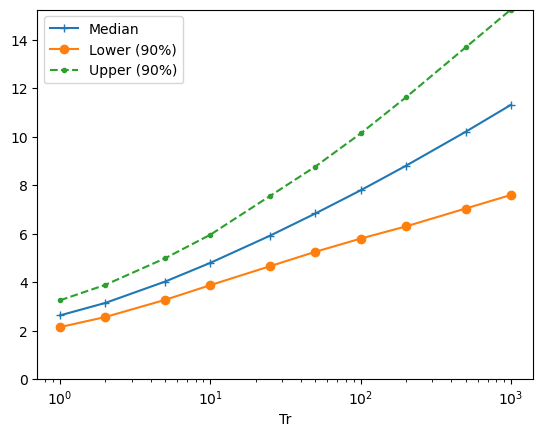

,Median,Lower (90%),Upper (90%)
Tr,,,
1,2.630202,2.146298,3.252532
2,3.142936,2.561979,3.888394


In [5]:
raw_precip = get_input_data(precip_table_dir, duration, lower_limit, display_print)
raw_precip.rename(columns = {'Expected Value': 'Median'}, inplace = True)
raw_precip.plot(style=['+-','o-','.--'], logx=True, ylim=(0, raw_precip['Upper (90%)'].max()))
plt.show()
raw_precip.head(2)

#### Fit GEV to rainfall data (find GEV parameters):

In [8]:
## Reduce precipitation by aerial reduction factor:
raw_precip_reduced = raw_precip[raw_precip.select_dtypes(include=['number']).columns]*Aerial_Reduction

## Find GEV parameter values:
df_GEV_parameters_M = GEV_parameters_Fit(raw_precip_reduced, 'Median', PMP)
df_GEV_parameters_U = GEV_parameters_Fit(raw_precip_reduced, 'Upper (90%)', PMP)
df_GEV_parameters_L = GEV_parameters_Fit(raw_precip_reduced, 'Lower (90%)', PMP)
df_GEV_parameters = pd.concat([df_GEV_parameters_M, df_GEV_parameters_L, df_GEV_parameters_U], axis=1)
df_GEV_parameters

C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey\notebooks\pluvial\../../core\hydromet_stratified.py:62: RuntimeWarning:

divide by zero encountered in scalar divide



,GEV Median,GEV Lower (90%),GEV Upper (90%)
mu,2.989852,2.437018,3.691266
sigma,0.711318,0.640669,0.875758
xi,-0.147999,-0.047004,-0.181070


In [9]:
raw_precip_reduced

,Median,Lower (90%),Upper (90%)
Tr,,,
1,2.630202,2.146298,3.252532
2,3.142936,2.561979,3.888394
5,4.024649,3.270277,4.986479
10,4.796957,3.877011,5.957798
25,5.920426,4.660915,7.559415
50,6.834468,5.253830,8.770957
100,7.790021,5.798085,10.136085
200,8.802117,6.300000,11.624670
500,10.205819,7.039649,13.688574


#### Plot fitted GEV distribution and NOAA data:

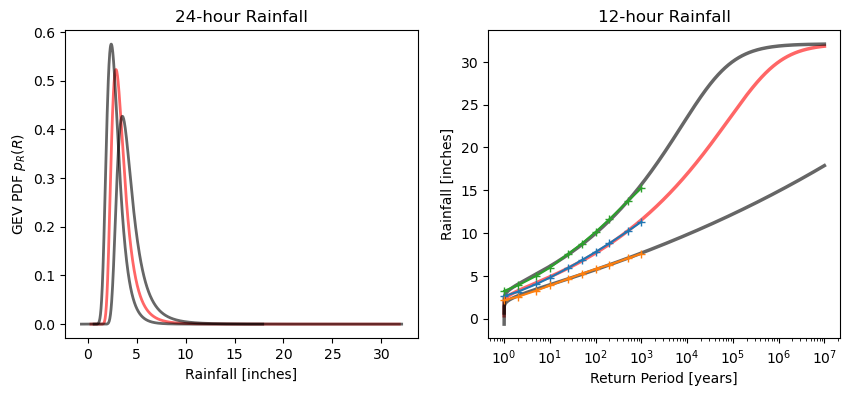

In [10]:
plot_GEV_precip_curves(raw_precip_reduced, df_GEV_parameters, PMP, 'Rainfall')
plt.show()

---
## Hydrology 1

In [11]:
Return_Intervals_Hydro1 = np.array([10, 25, 50, 100, 500])  # Hydrology 1 Return intervals for calculating runoff values.
GEV_parameters_M = df_GEV_parameters_M.values.transpose()[0]
df_weights_rainfall = weights_Rainfall(Return_Intervals_Hydro1, GEV_parameters_M, PMP, RI_upper_bound, raw_precip_reduced, 'Median', CN, mu)
df_weights_rainfall['Event Weight'].iloc[-2] = df_weights_rainfall['Event Weight'].iloc[-2]+df_weights_rainfall['Event Weight'].iloc[-1] # Add last event weight to the last event listed in the return intervals array
df_weights_rainfall = df_weights_rainfall[:-1].copy() # Drop the last event containing the rainfall amount of to the PMP
df_weights_rainfall

C:\Users\dneupane\AppData\Local\Temp\ipykernel_12424\1343539849.py:4: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




,Bin Floor,Bin Ceiling,Event Weight,Median,Runoff
10,6.764959,16.818562,0.088362,4.796957,3.180893
25,16.818562,42.365286,0.035854,5.920426,4.227507
50,42.365286,60.139533,0.006976,6.834468,5.094471
100,60.139533,211.001627,0.011889,7.790021,6.010807
500,211.001627,3700.000000,0.004739,10.205819,8.356230


#### Hydrology 1 Runoff Forcing Data:

In [12]:
#events and excess precip curves
prep_curves = precip_to_runoff_h1(Return_Intervals_Hydro1,nrcs_precip_table_dir,
                     raw_precip_reduced,df_weights_rainfall,CN)
final_curves = extend_time(prep_curves,Time_Extend,0.1)

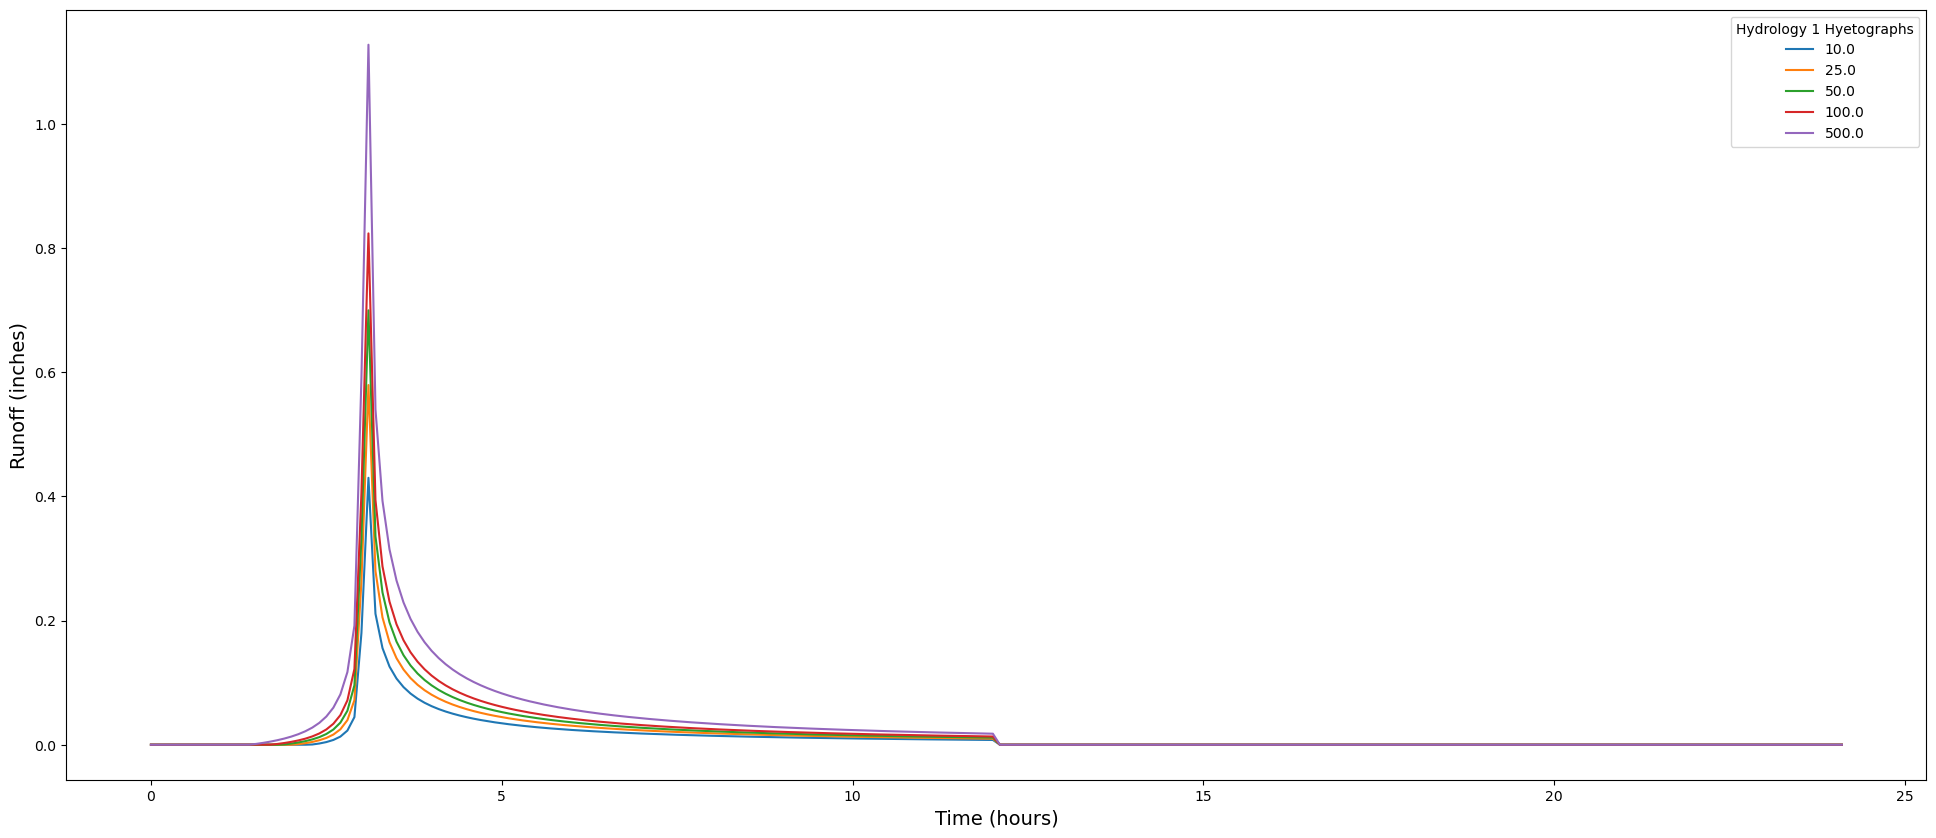

In [13]:
## test plot:
t_p = final_curves.plot(figsize=(24, 10))
t_p.legend(title='Hydrology 1 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();
plt.show()

#### Hydrology 1 Weights:

In [14]:
#formatting
Event_Weights_Hydro = df_weights_rainfall['Event Weight'].apply(lambda x: '%.20f' % x).to_dict()

ID_Hydrology = 1
rename_map = Rename_Final_Events_Precip_Stratified(Event_Weights_Hydro, ID_Hydrology) 
renamed_weights = {}

for k, v in rename_map.items():
    renamed_weights[v] = Event_Weights_Hydro [k]

renamed_weights

{'E1001': '0.08836244809828863733',
 'E1002': '0.03585388357199560672',
 'E1003': '0.00697623354646908708',
 'E1004': '0.01188869743942802884',
 'E1005': '0.00473929995870285559'}

In [15]:
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(10)

,E1001,E1002,E1003,E1004,E1005
hours,,,,,
0.0,0.0,0.0,0.0,0.0,0.0
0.1,0.0,0.0,0.0,0.0,0.0
0.2,0.0,0.0,0.0,0.0,0.0
0.3,0.0,0.0,0.0,0.0,0.0
0.4,0.0,0.0,0.0,0.0,0.0
0.5,0.0,0.0,0.0,0.0,0.0
0.6,0.0,0.0,0.0,0.0,0.0
0.7,0.0,0.0,0.0,0.0,0.0
0.8,0.0,0.0,0.0,0.0,0.0


In [16]:
#convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights 

,Weight
E1001,0.08836244809828863733
E1002,0.03585388357199560672
E1003,0.00697623354646908708
E1004,0.01188869743942802884
E1005,0.00473929995870285559


### Save Data

##### To CSV:

In [17]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration,ID_Hydrology))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration, ID_Hydrology))

In [18]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_Hydro{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, ID_Hydrology))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.close()

---
## Hydrology 2

### Mean Curve Calculation
#### Data for calculating the mean curve:

In [20]:
return_interval_Data = return_interval_data(raw_precip_reduced, return_intervals_mc, df_GEV_parameters, PMP)
return_interval_Data

,Median,Lower (90%),Upper (90%),Log SD (Lower),Log SD (Upper),Max Log SD,mu LN
1.00,2.630202,2.146298,3.252532,0.123597,0.129102,0.129102,0.967061
1.01,2.016331,1.491607,2.521379,0.183237,0.135883,0.183237,0.701279
1.05,2.259714,1.742076,2.808235,0.158152,0.132108,0.158152,0.815238
1.11,2.429277,1.910602,3.010373,0.146003,0.130377,0.146003,0.887594
1.25,2.662991,2.135518,3.291945,0.134189,0.128893,0.134189,0.979450
2.00,3.142936,2.561979,3.888394,0.124242,0.129385,0.129385,1.145157
5.00,4.024649,3.270277,4.986479,0.126178,0.130269,0.130269,1.392438
10.00,4.796957,3.877011,5.957798,0.129433,0.131744,0.131744,1.567982
20.00,5.643163,4.479166,7.135458,0.140430,0.142633,0.142633,1.730445
25.00,5.920426,4.660915,7.559415,0.145408,0.148563,0.148563,1.778408


#### Input for calculating the mean curve:

In [21]:
mean_curve_data = mean_curve_input_table(CL, return_interval_Data, PMP, precip_mean_curve_input_table_dir)
mean_curve_data

,0.001,0.005,0.010,0.050,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900,0.950,0.990,0.995,0.999
AEP,,,,,,,,,,,,,,,,,
1.000000e-07,25.360724,26.756190,27.387181,28.927010,29.624157,30.342916,30.773722,31.084142,31.327691,31.528503,31.699577,31.848732,31.981044,32.042017,32.088628,32.094328,32.098868
2.000000e-07,24.411871,25.973086,26.684403,28.434082,29.232609,30.060000,30.557902,30.917586,31.200322,31.433799,31.632952,31.806777,31.961120,32.032291,32.086719,32.093375,32.098678
5.000000e-07,22.486228,24.349370,25.213244,27.378206,28.385233,29.441252,30.082930,30.549382,30.917757,31.223091,31.484352,31.712999,31.916500,32.010492,32.082436,32.091238,32.098251
1.000000e-06,17.713824,20.073017,21.228239,24.309213,25.839813,27.516973,28.574145,29.361516,29.994928,30.527891,30.989762,31.398474,31.765822,31.936644,32.067892,32.083980,32.096801
2.000000e-06,13.389163,15.810667,17.067363,20.679471,22.634021,24.917577,26.442219,27.624984,28.607945,29.458096,30.212796,30.895179,31.520644,31.815537,32.043896,32.071996,32.094407
5.000000e-06,9.641056,11.715205,12.846966,16.355579,18.447701,21.114652,23.060918,24.682897,26.119015,27.435954,28.671759,29.850646,30.989307,31.547505,31.989902,32.044975,32.088999
1.000000e-05,8.072758,9.850433,10.835559,13.976936,15.930026,18.535832,20.542948,22.302534,23.942074,25.527872,27.103248,28.702302,30.356643,31.214885,31.920583,32.010134,32.082001
2.000000e-05,7.151969,8.686796,9.540300,12.289166,14.030300,16.411893,18.309659,20.035130,21.710854,23.412635,25.206414,27.167824,29.404440,30.678107,31.801507,31.949786,32.069799
5.000000e-05,6.466260,7.753766,8.466113,10.754178,12.207396,14.215363,15.845479,17.363995,18.886455,20.500515,22.308143,24.473452,27.349634,29.328493,31.446778,31.765310,32.031685


##### Calculate the mean precipitation curve:

Specified inputs_path is to a csv, loaded table.

Values increase with decreasing annual exceedance probability for all confidence limits as expected



C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey\notebooks\pluvial\../../core\meanffc.py:496: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



,P_Mean_in,P_Median_in
AEP,,
0.9,2.317395,2.431860
0.5,3.213507,3.142936


C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey\notebooks\pluvial\Outputs - already exists



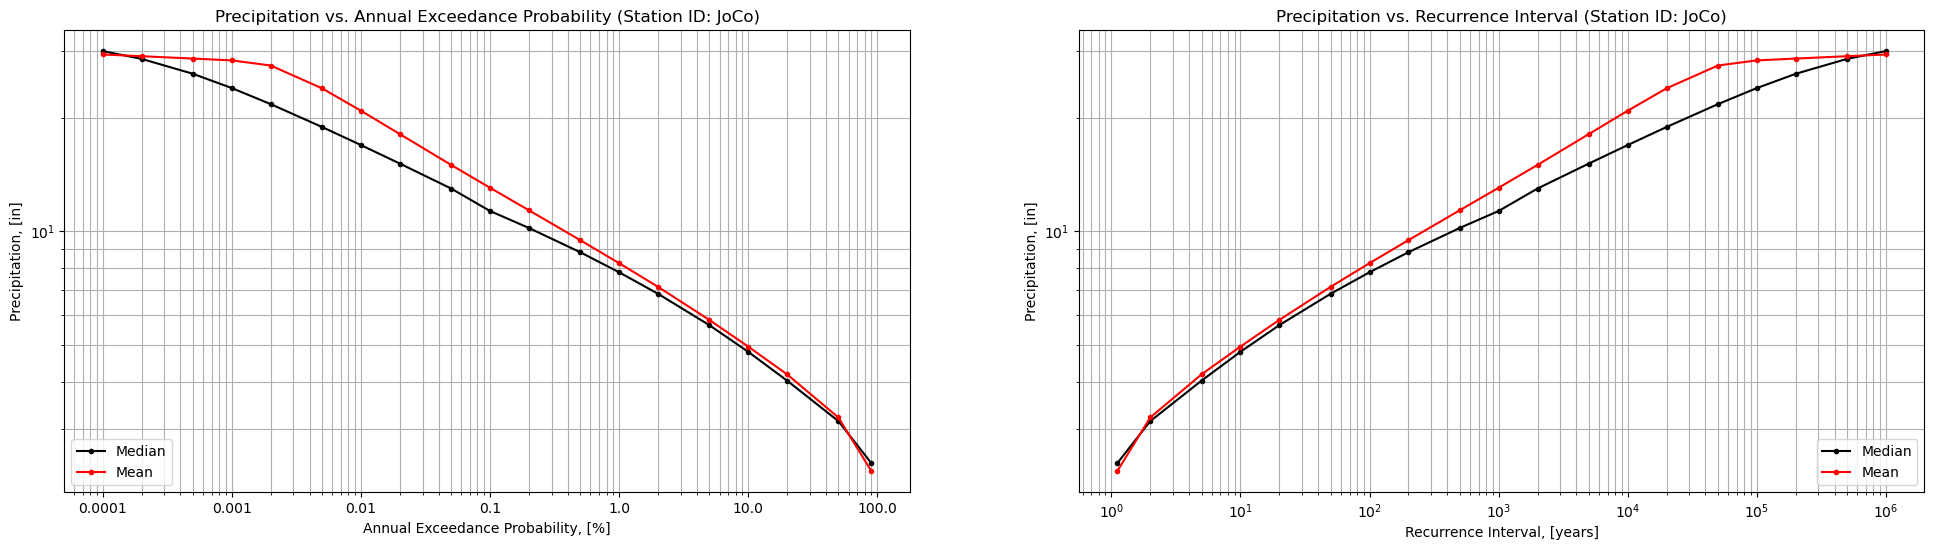

In [23]:
df = mean_frequency_curve.main(Project_Area, precip_mean_curve_input_table_dir, outputs_dir, data_type = 'P', round_decimals = 6)
plt.show()

In [24]:
df

,P_Mean_in,P_Median_in
AEP,,
0.900000,2.317395,2.431860
0.500000,3.213507,3.142936
0.200000,4.181504,4.024649
0.100000,4.952494,4.796957
0.050000,5.825823,5.643163
0.020000,7.129285,6.834468
0.010000,8.234988,7.790021
0.005000,9.473490,8.802117
0.002000,11.368734,10.205819


---
### Load Mean Curve:

In [25]:
mean_curve_precip = pd.read_csv(precip_mean_curve_table_dir, index_col=0)
mean_curve_precip['Tr'] = 1.0/mean_curve_precip.index.values
mean_curve_precip.set_index('Tr', inplace = True)
mean_curve_precip.plot(style=['+-', 'o-'], logx=True, ylim=(0, PMP))
mean_curve_precip.head(2)

,P_Mean_in,P_Median_in
Tr,,
1.111111,2.317395,2.431860
2.000000,3.213507,3.142936


### Fit GEV to Mean Precipication Curve (Find GEV Parameters):

C:\Users\dneupane\AppData\Local\Temp\ipykernel_12424\980014200.py:1: FutureWarning:

The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead



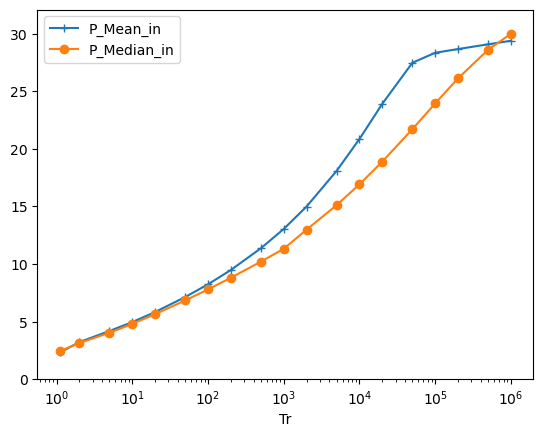

In [26]:
fit_values_mean_curve_precip = mean_curve_precip[1:20000] # Only fit the value up to about the 20,000 year event
df_GEV_parameters_E = GEV_parameters_Fit(fit_values_mean_curve_precip, 'P_Mean_in', PMP)
GEV_parameters_E = df_GEV_parameters_E.values.transpose()[0]
df_GEV_parameters = pd.concat([df_GEV_parameters, df_GEV_parameters_E], axis=1)
df_GEV_parameters
plt.show()

#### Plot fitted GEV distribution and mean precipitation curve:

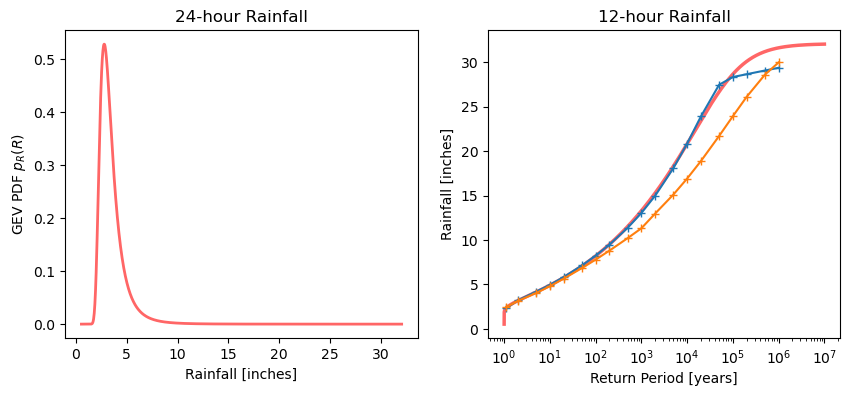

In [27]:
plot_GEV_precip_curves(mean_curve_precip, df_GEV_parameters_E, PMP, 'Rainfall')
plt.show()

### Hydrology 2 Events:

In [28]:
df_weights_rainfall = weights_Rainfall(Return_Intervals, GEV_parameters_E, PMP, RI_upper_bound, mean_curve_precip, 'P_Mean_in', CN, mu)
df_weights_rainfall.head(2)

,Bin Floor,Bin Ceiling,Event Weight,P_Mean_in,Runoff
2.0,1.262177,4.091669,0.547883,3.213507,1.769158
5.0,4.091669,6.286541,0.085329,4.181504,2.620631


#### Hydrology 2 Runoff Forcing Data:

In [29]:
#events and excess precip curves
hydro_events = df_weights_rainfall.index.to_numpy().tolist()
prep_curves = precip_to_runoff_h2(hydro_events,nrcs_precip_table_dir,df_weights_rainfall,df_weights_rainfall,CN)
final_curves = extend_time(prep_curves,Time_Extend,0.1)

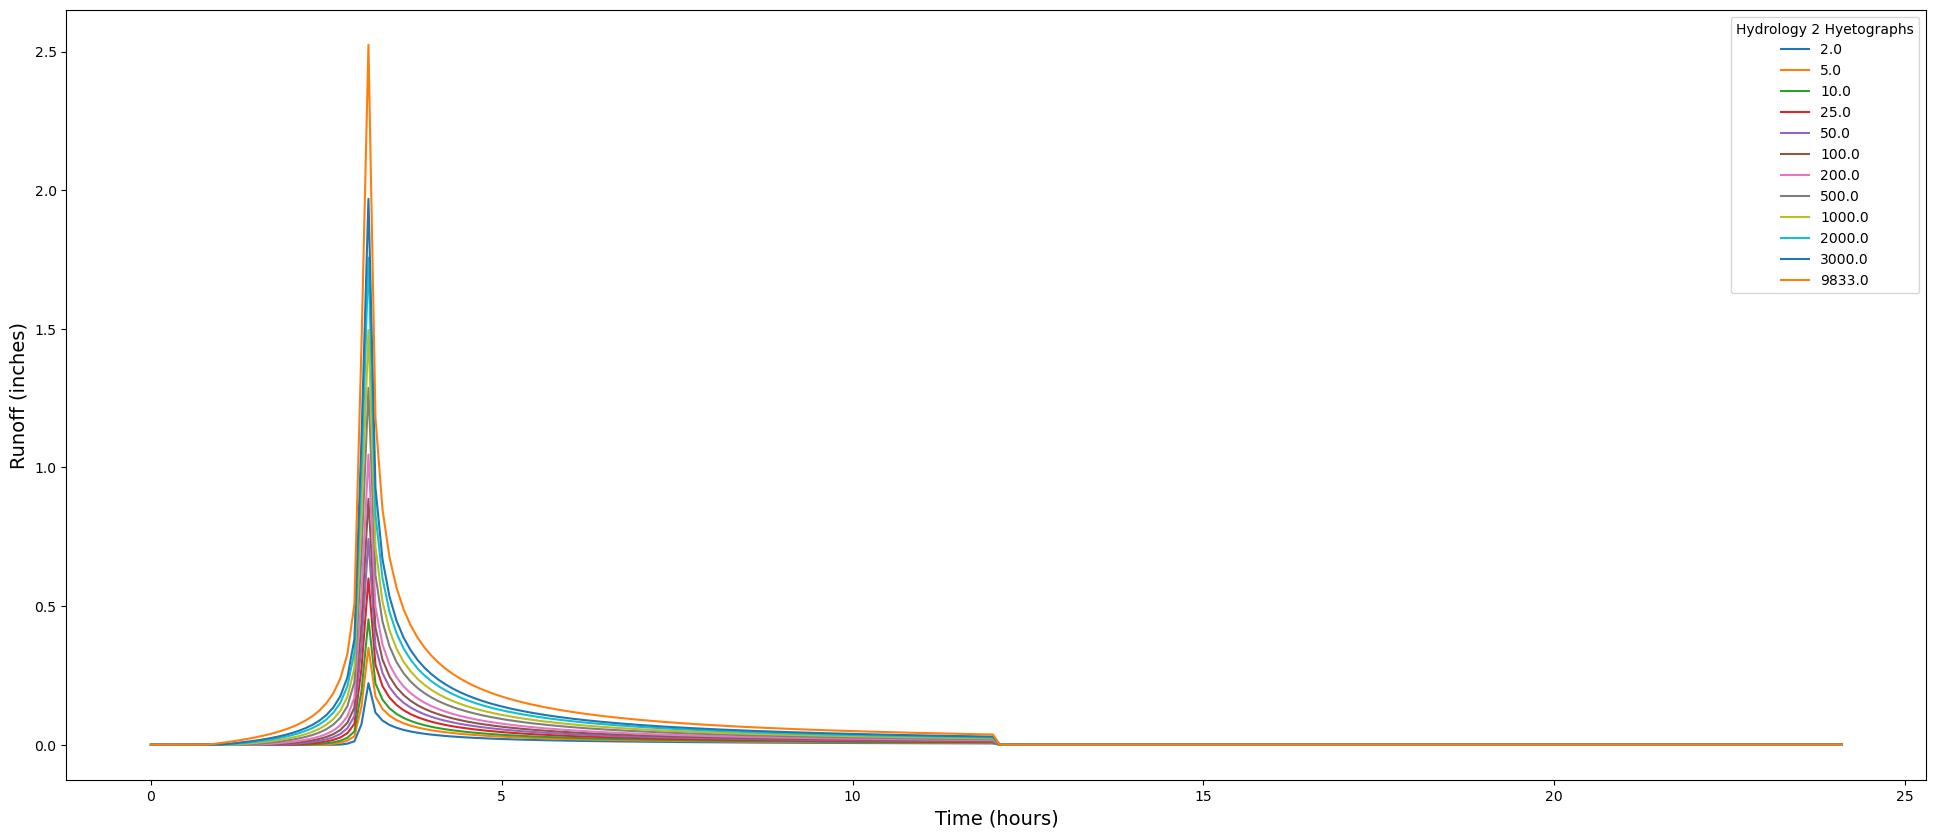

In [30]:
#graph
t_p = final_curves.plot(figsize=(24, 10))
t_p.legend(title='Hydrology 2 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();
plt.show()

#### Hydrology 2 Weights:

In [31]:
#formatting
Event_Weights_Hydro = df_weights_rainfall['Event Weight'].apply(lambda x: '%.20f' % x).to_dict()

ID_Hydrology = 2
rename_map = Rename_Final_Events_Precip_Stratified(Event_Weights_Hydro, ID_Hydrology) #set naming convention
renamed_weights = {}

for k, v in rename_map.items():
    renamed_weights[v] = Event_Weights_Hydro[k]

renamed_weights

{'E2001': '0.54788260528785748260',
 'E2002': '0.08532904476134978156',
 'E2003': '0.10702009073699439434',
 'E2004': '0.02279241154501444877',
 'E2005': '0.01706473975011726929',
 'E2006': '0.00420815547496868753',
 'E2007': '0.00538714011341108294',
 'E2008': '0.00113141847104740131',
 'E2009': '0.00085903240307738963',
 'E2010': '0.00020563101828503859',
 'E2011': '0.00013111027204394042',
 'E2012': '0.00027027027027027027'}

In [32]:
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(10)

,E2001,E2002,E2003,E2004,E2005,E2006,E2007,E2008,E2009,E2010,E2011,E2012
hours,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000364


In [33]:
#convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight':list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights 

,Weight
E2001,0.54788260528785748260
E2002,0.08532904476134978156
E2003,0.10702009073699439434
E2004,0.02279241154501444877
E2005,0.01706473975011726929
E2006,0.00420815547496868753
E2007,0.00538714011341108294
E2008,0.00113141847104740131
E2009,0.00085903240307738963
E2010,0.00020563101828503859


### Save

##### To CSV:

In [34]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration,ID_Hydrology))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration, ID_Hydrology))

In [35]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_Hydro{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, ID_Hydrology))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.close()

---
## Hydrology 3:
### Retrieve Max Potential Retention Variability and Distribution Parameters:

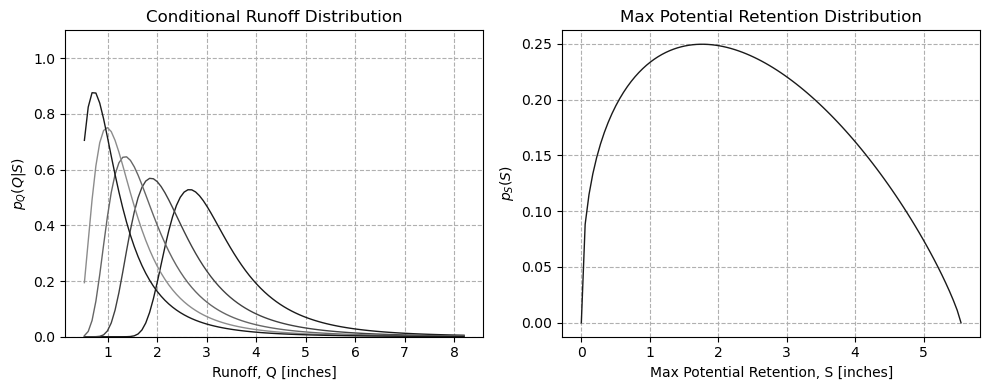

In [36]:
## NRCS value of wet and dry soil moiture conditions:
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

## Table of wet, dry, and average (or median) soil moisture conditions:
df_CN = prep_cn_table(CN, arc_data)  

## Table of parameters for best fit of beta-type distribution to NRCS estiamted dispersion:
fitted_cn = find_optimal_curve_beta_dist_S(df_CN)
fitted_cn['mu'] = mu

## Distribution parameter values:
S_limit = 1000.0/fitted_cn.iloc[0]['CN Lower Limit']-10.0
alpha = fitted_cn.iloc[0]['alpha']
beta = fitted_cn.iloc[0]['beta']

## Define probability for each partition of the max potential retention distribution:
Delta_P = 1.0/n_partition

## Find the average value over each partition, which is the basis for the runoff distribution:
partition_avg = partition_S_avgs(n_partition, Delta_P, alpha, beta, S_limit)

plot_runoff_maxRetention_distributions(GEV_parameters_E, PMP, fitted_cn)
plt.show()

In [37]:
df_CN

,AMC I (Dry),AMC II,AMC III (Wet)
1,70,85,94


In [38]:
fitted_cn

,AMC I (Dry),AMC II,AMC III (Wet),alpha,beta,CN Lower Limit,Fitted AMC I (Dry),Fitted AMC II,Fitted AMC III (Wet),mu
1,70,85,94,1.392002,1.840343,64.320629,70.000046,85.001444,93.998659,0.2


In [39]:
S_limit, alpha, beta

(5.547111716274683, 1.3920022969662778, 1.8403429081660123)

#### Calculate the error in the numerical CDF evaluated at PMP:

In [40]:
## Error between the integral approach (based on summation integration) and the actual value:
error_PQ = 1-CDF_Q(PMP, mu, alpha, beta, S_limit, GEV_parameters_E, PMP, partition_avg, Delta_P, 0)

print('\nProbability of zero runoff = {}\nError in calculation of Probabilibity of zero runoff = {}\n'
      'Error, i.e., the difference between 1 and the numerical CDF evaluated at PMP, Error = {}'
      ''.format(P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP, error_PQ)[0], P_Qzero(mu, alpha, beta, S_limit, GEV_parameters_E, PMP, error_PQ)[1], error_PQ))


Probability of zero runoff = 3.9315692007684704e-18
Error in calculation of Probabilibity of zero runoff = 6.974884202986734e-18
Error, i.e., the difference between 1 and the numerical CDF evaluated at PMP, Error = -4.148373129231331e-06


### Determine Runoff Values and Weights:
#### Fit GEV to runoff data (find GEV parameters):

In [41]:
df_runoff, df_GEV_parameters_R = runoff_GEV(mu, GEV_parameters_E, PMP, alpha, beta, S_limit, partition_avg, Delta_P, error_PQ)
GEV_parameters_R = df_GEV_parameters_R.values.transpose()[0]
df_GEV_parameters_R

,GEV Runoff
mu,1.404714
sigma,0.653266
xi,-0.202788


In [42]:
df_runoff

,Runoff
1.000000e+00,0.010
1.208041e+00,0.812
2.058959e+00,1.614
4.172484e+00,2.416
9.024542e+00,3.218
1.855804e+01,4.020
3.528902e+01,4.822
6.246258e+01,5.624
1.041502e+02,6.426
1.653466e+02,7.228


#### Plot fitted rainfall and runoff GEV distributions:

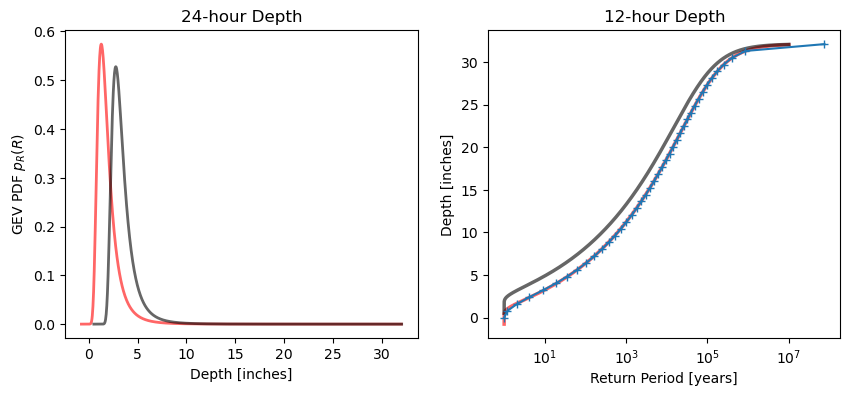

In [43]:
plot_GEV_precip_curves(df_runoff, pd.concat([df_GEV_parameters_R, df_GEV_parameters_E], axis=1), PMP, 'Depth')
plt.show()

#### Runoff weights:

In [44]:
df_weights_runoff = runoff_weights(Return_Intervals, RI_upper_bound, mu, GEV_parameters_R,  GEV_parameters_E, PMP, partition_avg, Delta_P, error_PQ)
df_weights_runoff.head(2)

,Bin Floor,Bin Ceiling,Event Weight,Runoff
2,1.261622,4.095088,0.548435,1.653257
5,4.095088,6.283000,0.085035,2.549891


In [45]:
df_weights_runoff

,Bin Floor,Bin Ceiling,Event Weight,Runoff
2,1.261622,4.095088,0.548435,1.653257
5,4.095088,6.283000,0.085035,2.549891
10,6.283000,19.213845,0.107114,3.267570
25,19.213845,34.159485,0.022771,4.345299
50,34.159485,82.050517,0.017087,5.289712
100,82.050517,125.155337,0.004198,6.369865
200,125.155337,385.088056,0.005393,7.608461
500,385.088056,681.665909,0.001130,9.530261
1000,681.665909,1647.714250,0.000860,11.232130
2000,1647.714250,2491.706022,0.000206,13.174949


#### Plot runoff distribution:

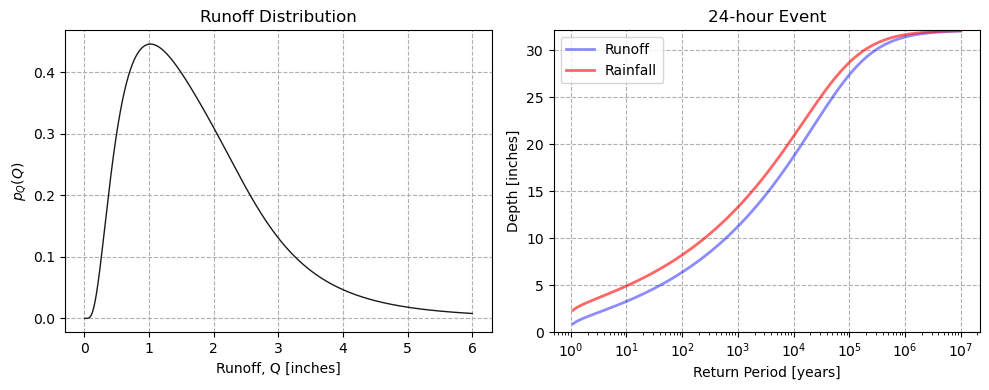

In [46]:
plot_runoff_distributions_final(GEV_parameters_E, GEV_parameters_R, PMP, fitted_cn, partition_avg, Delta_P, error_PQ)
plt.show()

#### Plot maximum potential distribution conditional on runoff:

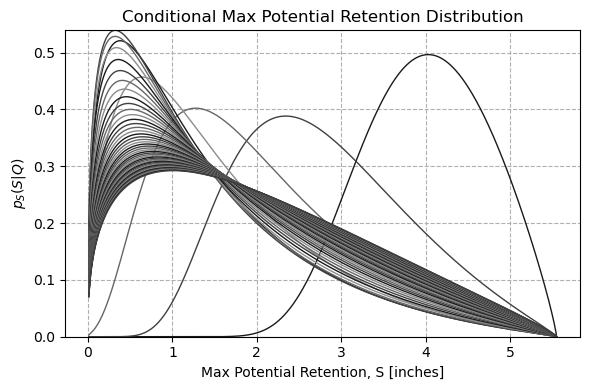

In [47]:
plot_max_potential_retention_cond_runoff(GEV_parameters_E, PMP, fitted_cn, partition_avg, Delta_P, error_PQ)
plt.show()

### Calculate Runoff and Corresponding Max Potential Retention and Rainfall:

In [48]:
df_runoff_SR1 = Scenarios_Avg_S_Median_S(df_weights_runoff, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ)
df_runoff_SR1.head(2)

,Bin Floor,Bin Ceiling,Event Weight,Runoff,Avg. S,Rainfall (Avg. S),Median S,Rainfall (Median S)
2,1.261622,4.095088,0.548435,1.653257,2.128736,3.302415,1.952668,3.194933
5,4.095088,6.283000,0.085035,2.549891,1.490965,3.902792,1.229988,3.703103


In [49]:
df_runoff_SR1

,Bin Floor,Bin Ceiling,Event Weight,Runoff,Avg. S,Rainfall (Avg. S),Median S,Rainfall (Median S)
2,1.261622,4.095088,0.548435,1.653257,2.128736,3.302415,1.952668,3.194933
5,4.095088,6.283000,0.085035,2.549891,1.490965,3.902792,1.229988,3.703103
10,6.283000,19.213845,0.107114,3.267570,1.376769,4.586440,1.083873,4.342724
25,19.213845,34.159485,0.022771,4.345299,1.395006,5.735265,1.094023,5.469483
50,34.159485,82.050517,0.017087,5.289712,1.450228,6.764595,1.152252,6.493364
100,82.050517,125.155337,0.004198,6.369865,1.516100,7.938001,1.227680,7.668859
200,125.155337,385.088056,0.005393,7.608461,1.584507,9.271650,1.305399,9.005376
500,385.088056,681.665909,0.001130,9.530261,1.673123,11.316809,1.410496,11.059622
1000,681.665909,1647.714250,0.000860,11.232130,1.736824,13.108248,1.484993,12.857113
2000,1647.714250,2491.706022,0.000206,13.174949,1.796757,15.136271,1.556441,14.892564


### Hydrology 3 Events:
- For each runoff value, two events are considered, a high max potential retention and a low max potential retention

In [50]:
df_runoff_SR2 = Scenarios_low_and_high_S(df_runoff_SR1, mu, GEV_parameters_E, PMP, partition_avg, Delta_P, alpha, beta, S_limit, error_PQ)
df_runoff_SR2.head(10)

,Event Weight,Runoff,Avg. S (Lower 50%),Rainfall (Lower 50%),Avg. S (Upper 50%),Rainfall (Upper 50%)
2,0.274218,1.653257,1.270632,2.749286,2.986840,3.794931
5,0.042518,2.549891,0.643591,3.211030,2.338340,4.497246
10,0.053557,3.267570,0.537191,3.844688,2.216346,5.225279
25,0.011386,4.345299,0.535904,4.934838,2.254108,6.433350
50,0.008543,5.289712,0.566045,5.918679,2.334410,7.509876
100,0.002099,6.369865,0.607584,7.049980,2.424616,8.728341
200,0.002697,7.608461,0.650635,8.341454,2.518380,10.107318
500,0.000565,9.530261,0.710677,10.336760,2.635569,12.207743
1000,0.000430,11.232130,0.753297,12.091384,2.720351,14.040207
2000,0.000103,13.174949,0.794870,14.085876,2.798644,16.106378


In [51]:
#formatting
hydro_events_orig = list(df_runoff_SR2.index)
relabel_U = [str(hyetograph)+'_U' for hyetograph in hydro_events_orig]
relabel_L = [str(hyetograph)+'_L' for hyetograph in hydro_events_orig]

df_runoff_SR2_U = df_runoff_SR2[['Event Weight', 'Runoff', 'Avg. S (Upper 50%)', 'Rainfall (Upper 50%)']].copy()
df_runoff_SR2_U.rename(columns = {'Avg. S (Upper 50%)': 'Avg. S', 'Rainfall (Upper 50%)': 'Rainfall'}, inplace = True)
df_runoff_SR2_U.index = relabel_U

df_runoff_SR2_L = df_runoff_SR2[['Event Weight', 'Runoff', 'Avg. S (Lower 50%)',  'Rainfall (Lower 50%)']].copy()
df_runoff_SR2_L.rename(columns = {'Avg. S (Lower 50%)': 'Avg. S', 'Rainfall (Lower 50%)': 'Rainfall'}, inplace = True)
df_runoff_SR2_L.index = relabel_L

#df_weights_rainfall = df_runoff_SR2_U.append(df_runoff_SR2_L).sort_values(by=['Runoff'])
df_weights_rainfall = pd.concat([df_runoff_SR2_U, df_runoff_SR2_L]).sort_values(by=['Runoff'])
df_weights_rainfall.head(2)

,Event Weight,Runoff,Avg. S,Rainfall
2_U,0.274218,1.653257,2.986840,3.794931
2_L,0.274218,1.653257,1.270632,2.749286


In [52]:
df_weights_rainfall

,Event Weight,Runoff,Avg. S,Rainfall
2_U,0.274218,1.653257,2.986840,3.794931
2_L,0.274218,1.653257,1.270632,2.749286
5_U,0.042518,2.549891,2.338340,4.497246
5_L,0.042518,2.549891,0.643591,3.211030
10_U,0.053557,3.267570,2.216346,5.225279
10_L,0.053557,3.267570,0.537191,3.844688
25_U,0.011386,4.345299,2.254108,6.433350
25_L,0.011386,4.345299,0.535904,4.934838
50_U,0.008543,5.289712,2.334410,7.509876
50_L,0.008543,5.289712,0.566045,5.918679


#### Hydrology 3 Runoff Forcing Data:

In [53]:
#events and excess precip curves
RI_list = np.sort(np.concatenate((df_runoff_SR2.index.to_numpy(), df_runoff_SR2.index.to_numpy())))
prep_curves = precip_to_runoff_h3(RI_list,nrcs_precip_table_dir, df_weights_rainfall,df_weights_rainfall)
final_curves = extend_time(prep_curves,Time_Extend,0.1)

In [54]:
final_curves

,2_U,2_L,5_U,5_L,10_U,10_L,25_U,25_L,50_U,50_L,...,500_L,500_U,1000_L,1000_U,2000_L,2000_U,3000_L,3000_U,9740_U,9740_L
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
23.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
23.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


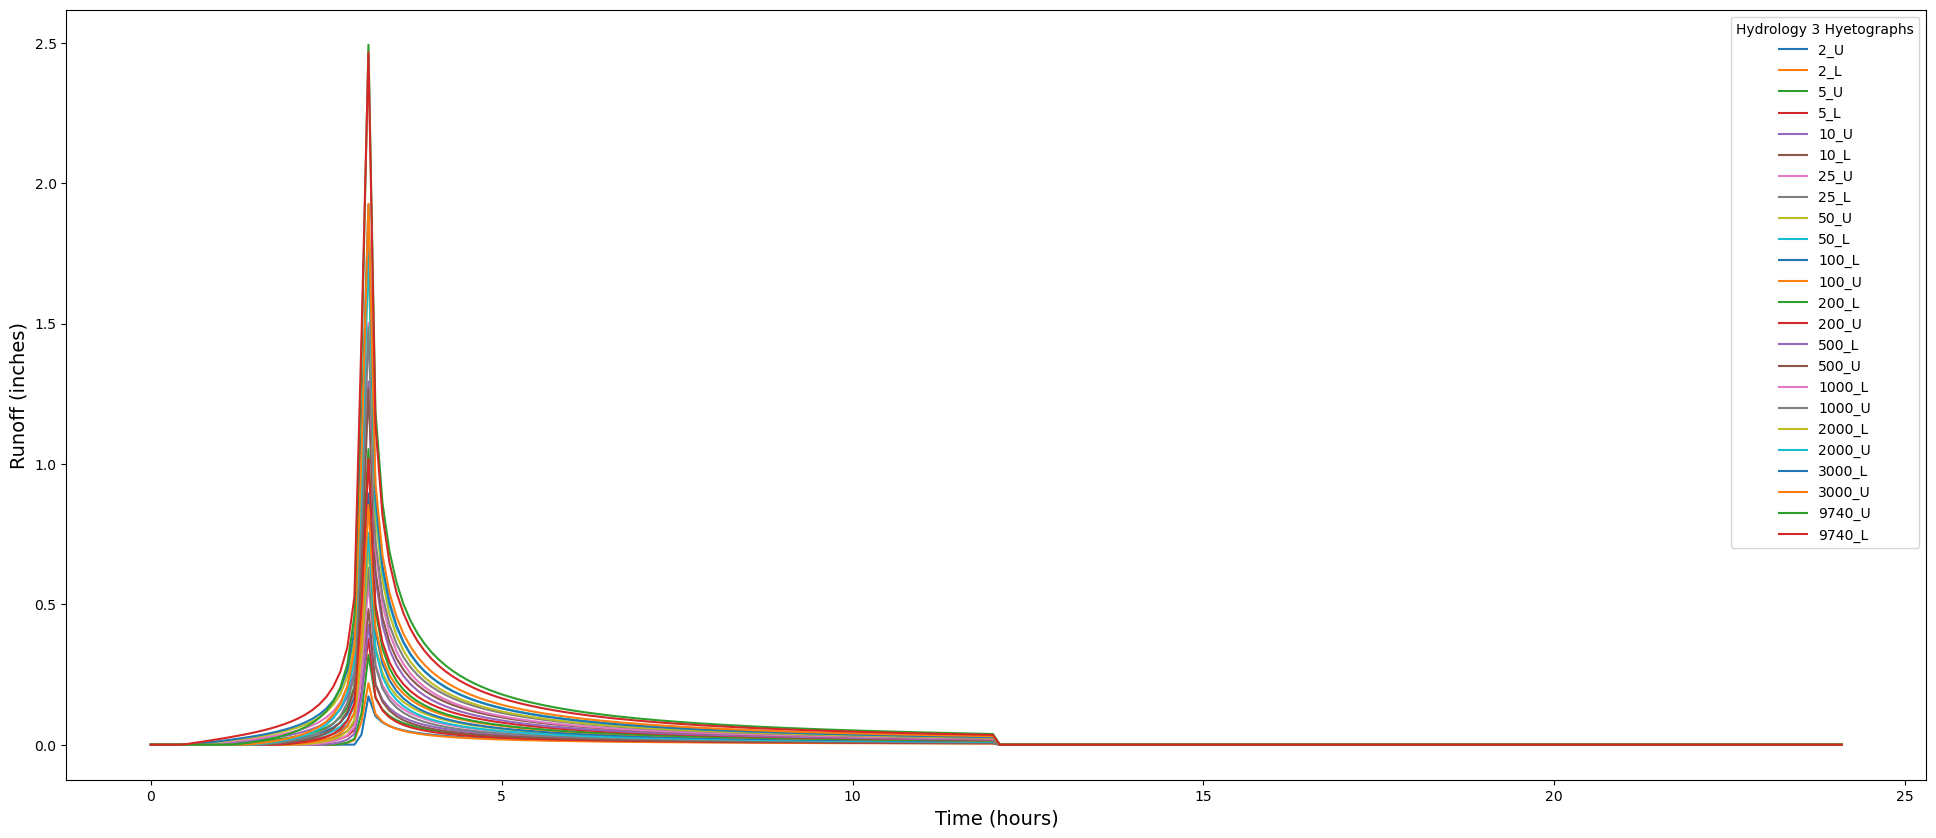

In [55]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title='Hydrology 3 Hyetographs')
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)',fontsize=14)
t_p.plot();
plt.show()

#### Hydrology 3 Weights:

In [56]:
#formatting
Event_Weights_Hydro = df_weights_rainfall['Event Weight'].apply(lambda x: '%.20f' % x).to_dict()

ID_Hydrology = 3
rename_map = Rename_Final_Events_Precip_Stratified(Event_Weights_Hydro, ID_Hydrology) #set naming convention
renamed_weights = {}

for k, v in rename_map.items():
    renamed_weights[v] = Event_Weights_Hydro [k]

renamed_weights

{'E3001': '0.27421760949905743532',
 'E3002': '0.27421760949905743532',
 'E3003': '0.04251768070943151567',
 'E3004': '0.04251768070943151567',
 'E3005': '0.05355691868311876491',
 'E3006': '0.05355691868311876491',
 'E3007': '0.01138567830392865805',
 'E3008': '0.01138567830392865805',
 'E3009': '0.00854341634663801502',
 'E3010': '0.00854341634663801502',
 'E3011': '0.00209877147977841332',
 'E3012': '0.00209877147977841332',
 'E3013': '0.00269663103961747044',
 'E3014': '0.00269663103961747044',
 'E3015': '0.00056490718496902785',
 'E3016': '0.00056490718496902785',
 'E3017': '0.00043004647355898175',
 'E3018': '0.00043004647355898175',
 'E3019': '0.00010278494738098139',
 'E3020': '0.00010278494738098139',
 'E3021': '0.00006553059171647742',
 'E3022': '0.00006553059171647742',
 'E3023': '0.00013513513513513514',
 'E3024': '0.00013513513513513514'}

In [57]:
renamed_curves = final_curves.rename(columns=rename_map).copy()

renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(10)

,E3001,E3002,E3003,E3004,E3005,E3006,E3007,E3008,E3009,E3010,...,E3015,E3016,E3017,E3018,E3019,E3020,E3021,E3022,E3023,E3024
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000
0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000002
0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000084,0.0,0.0,0.002032
0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000179,0.0,0.001103,0.0,0.002035,0.0,0.0,0.005822
0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000566,0.0,0.001841,0.0,0.003547,0.0,0.004791,0.0,0.0,0.009624
0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.002190,0.0,0.003891,0.0,0.006063,0.0,0.007612,0.0,0.0,0.013473


In [58]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights.head(2)

,Weight
E3001,0.27421760949905743532
E3002,0.27421760949905743532


### Save

##### To CSV:

In [59]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration,ID_Hydrology))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration, ID_Hydrology))

In [60]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_Hydro{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, ID_Hydrology))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.close()

---
## Hydrology 4
*Events are the same as Hydrology 3*

#### Hydrology 4 Runoff Forcing Data:

In [61]:
#events and excess precip curves
RI_list = np.sort(np.concatenate((df_runoff_SR2.index.to_numpy(), df_runoff_SR2.index.to_numpy())))
prep_curves, prep_weights = precip_to_runoff_h4(RI_list,atlas14_precip_table_dir,
                     df_weights_rainfall,df_weights_rainfall)
final_curves = extend_time(prep_curves,Time_Extend,0.5)

C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey\notebooks\pluvial\../../core\hydromet_stratified.py:827: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey\notebooks\pluvial\../../

In [62]:
final_curves

,2_U_q1,2_U_q2,2_U_q3,2_U_q4,2_L_q1,2_L_q2,2_L_q3,2_L_q4,5_U_q1,5_U_q2,...,3000_U_q3,3000_U_q4,9740_U_q1,9740_U_q2,9740_U_q3,9740_U_q4,9740_L_q1,9740_L_q2,9740_L_q3,9740_L_q4
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.5,0.087780,0.000000,0.000000,0.000000,0.183235,0.000000,0.000000,0.000000,0.250748,0.000000,...,0.000000,0.000000,4.049045,0.357422,0.000000,0.000000,5.023831,0.907649,0.000000,0.000000
1.0,0.453095,0.000055,0.000000,0.000000,0.486299,0.024221,0.000000,0.000000,0.743380,0.025165,...,0.000000,0.000000,5.421192,1.085022,0.000000,0.000000,5.173703,1.387743,0.000000,0.022729
1.5,0.459764,0.013286,0.000000,0.000000,0.422990,0.043140,0.000000,0.000000,0.664339,0.058102,...,0.000000,0.000000,4.055553,0.872632,0.000000,0.000000,3.753481,0.957769,0.011843,0.055380
2.0,0.323509,0.026725,0.000000,0.000000,0.281958,0.047698,0.000000,0.000000,0.447121,0.067790,...,0.000000,0.000000,2.569951,0.772440,0.000000,0.000004,2.358047,0.803500,0.039380,0.025904
2.5,0.186733,0.063442,0.000000,0.000000,0.159001,0.088641,0.000000,0.000000,0.253180,0.130028,...,0.000000,0.000000,1.419224,1.230363,0.000000,0.000206,1.297895,1.232992,0.031317,0.009863
3.0,0.091044,0.147782,0.000000,0.000000,0.076724,0.172011,0.000000,0.000000,0.122392,0.259462,...,0.000000,0.000000,0.678638,2.058156,0.000000,0.002728,0.619760,1.992656,0.011923,0.033501
3.5,0.036795,0.256793,0.000000,0.000000,0.030874,0.262077,0.000000,0.000000,0.049288,0.404167,...,0.000000,0.002491,0.272061,2.774933,0.000175,0.013012,0.248317,2.617179,0.018414,0.069673
4.0,0.011626,0.328717,0.000000,0.000000,0.009740,0.307788,0.000000,0.000000,0.015553,0.481906,...,0.000086,0.011389,0.085708,2.999879,0.005998,0.026359,0.078212,2.784494,0.056806,0.088965


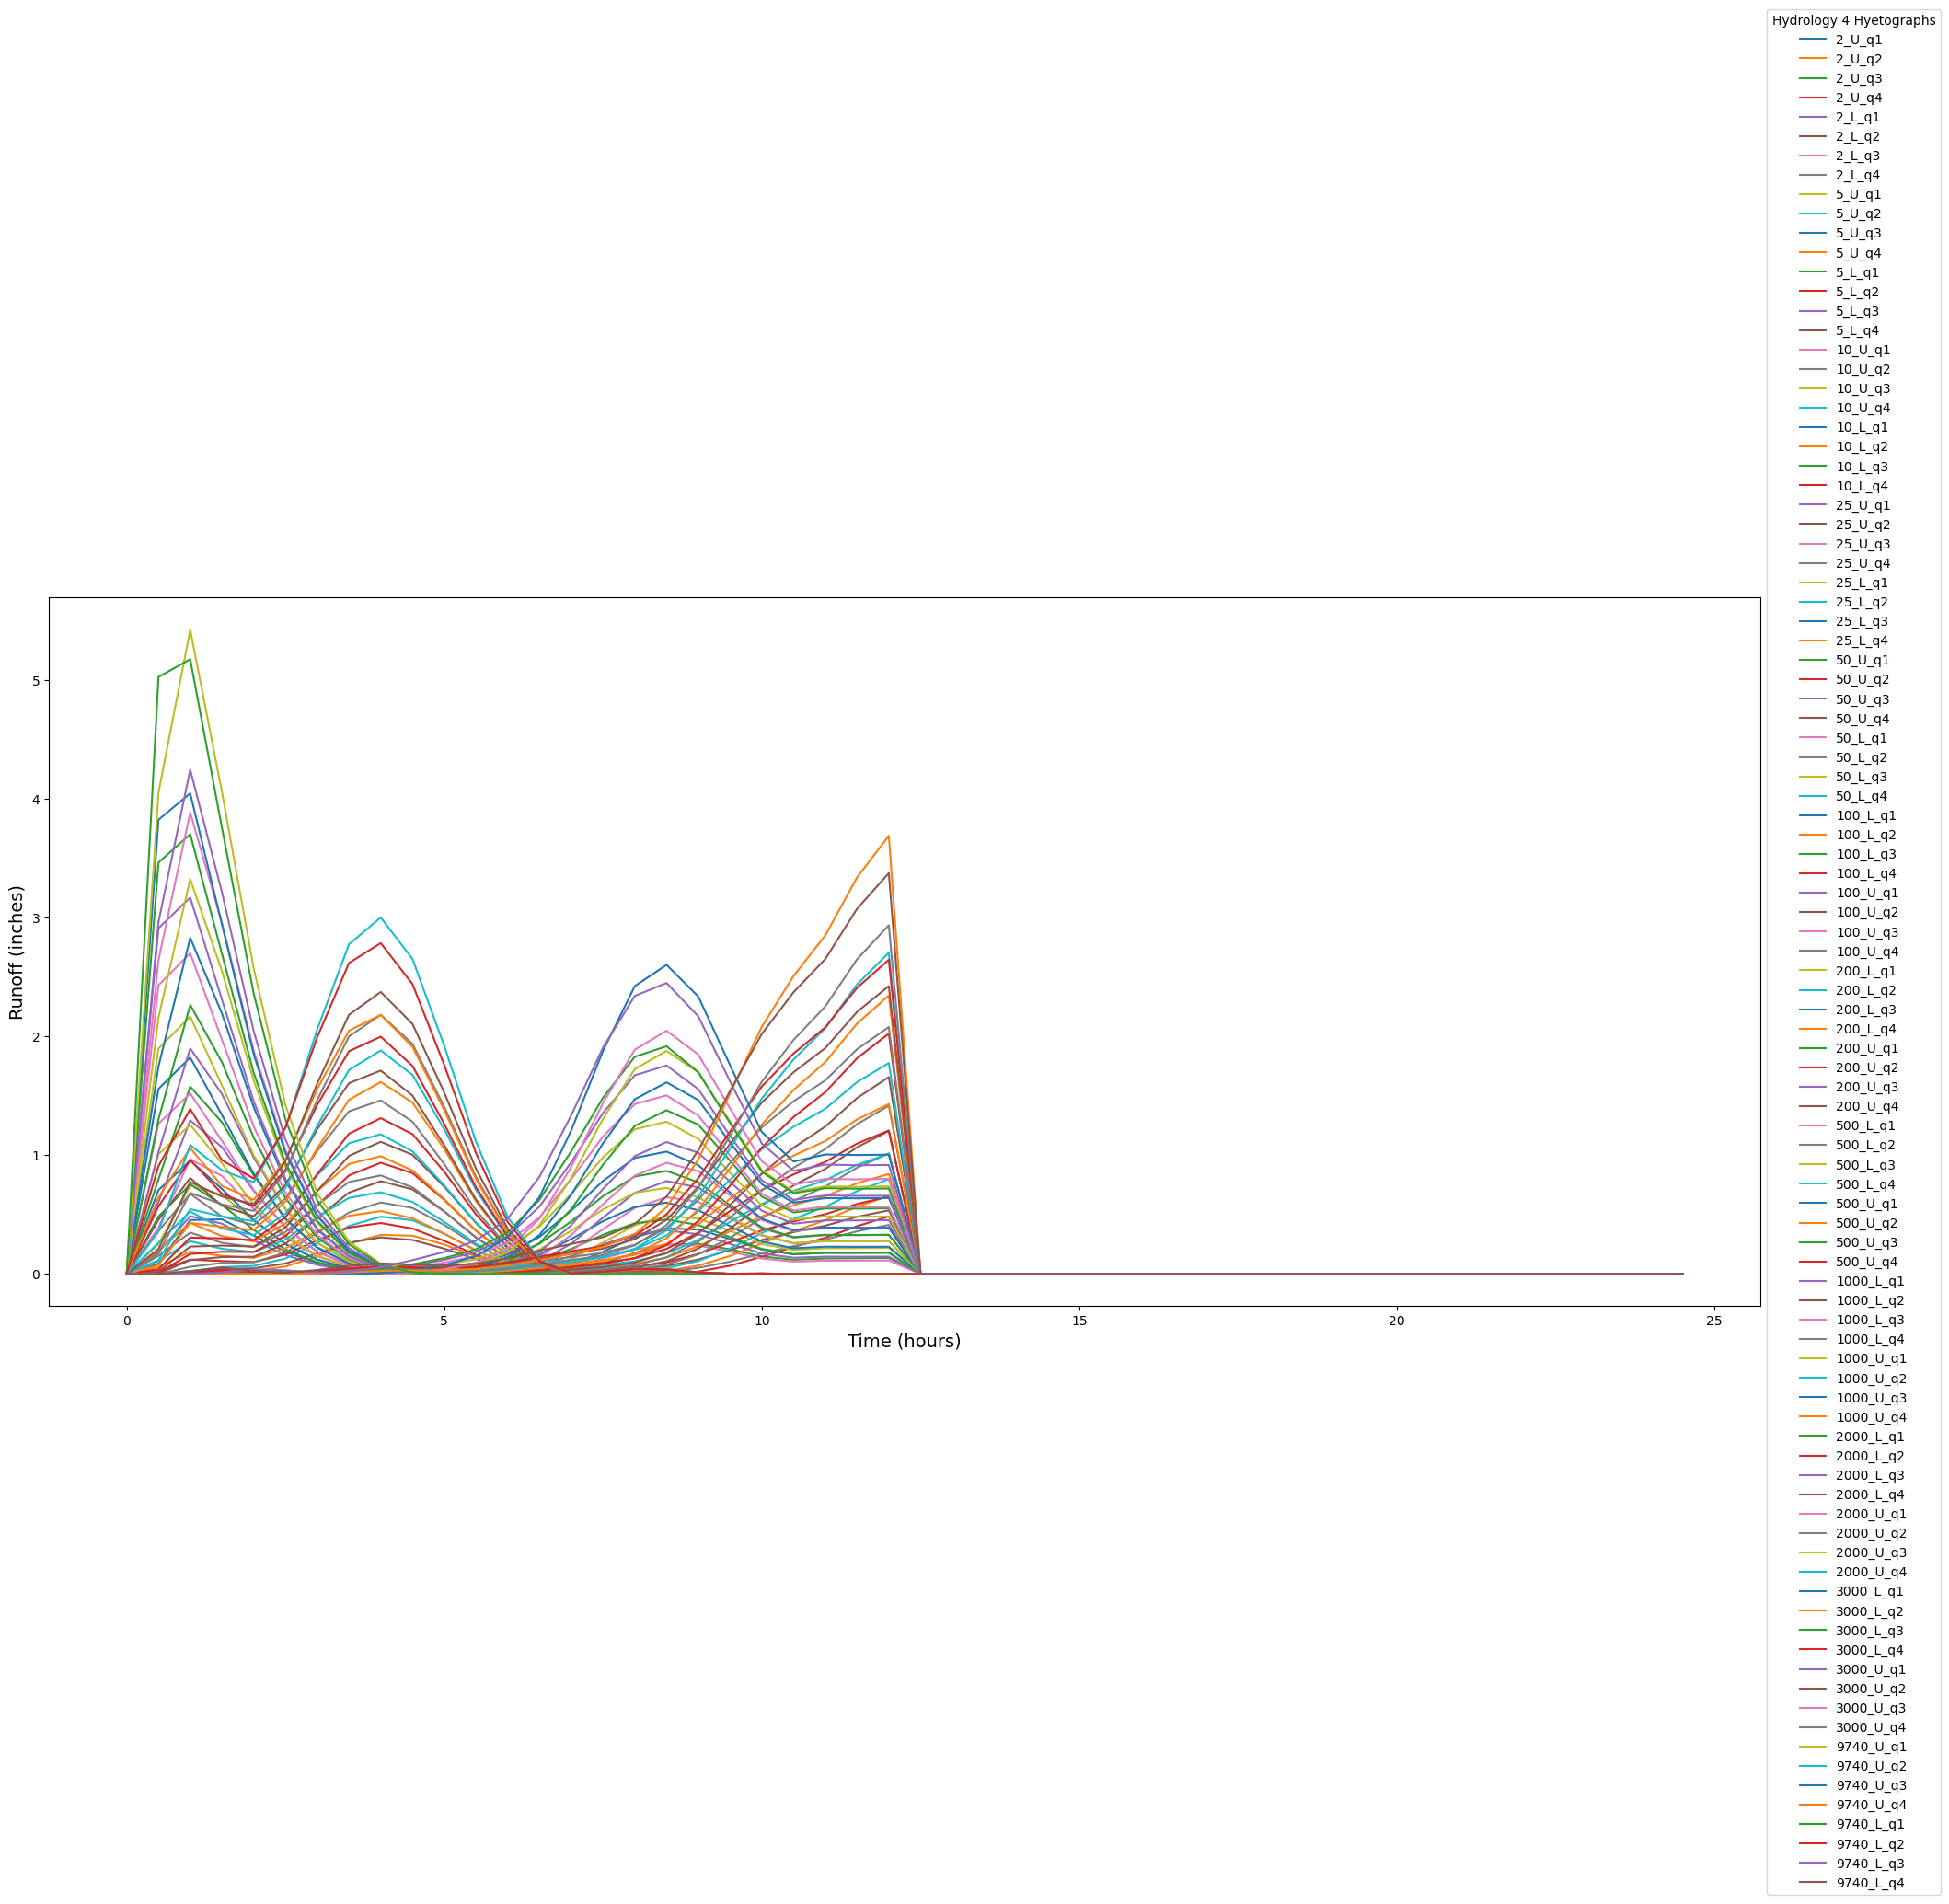

In [63]:
## graph
t_p = final_curves.plot(figsize=(24,10))
t_p.legend(title='Hydrology 4 Hyetographs',loc='center left', bbox_to_anchor=(1.0, 0.5))
t_p.set_xlabel('Time (hours)', fontsize=14)
t_p.set_ylabel('Runoff (inches)', fontsize=14)
t_p.plot();
plt.show()

#### Hydrology 4 Weights:

In [64]:
Event_Weights_Hydro = prep_weights['Event Weight'].apply(lambda x: '%.20f' % x).to_dict()

ID_Hydrology = 4
rename_map = Rename_Final_Events_Precip_Stratified(Event_Weights_Hydro, ID_Hydrology) #set naming convention
renamed_weights = {}

for k, v in rename_map.items():
    renamed_weights[v] = Event_Weights_Hydro[k]
    
renamed_weights

{'E4001': '0.15356186131947216489',
 'E4002': '0.06032787408979263521',
 'E4003': '0.03839046532986804122',
 'E4004': '0.02193740875992459399',
 'E4005': '0.15356186131947216489',
 'E4006': '0.06032787408979263521',
 'E4007': '0.03839046532986804122',
 'E4008': '0.02193740875992459399',
 'E4009': '0.02380990119728165072',
 'E4010': '0.00935388975607493421',
 'E4011': '0.00595247529932041268',
 'E4012': '0.00340141445675452153',
 'E4013': '0.02380990119728165072',
 'E4014': '0.00935388975607493421',
 'E4015': '0.00595247529932041268',
 'E4016': '0.00340141445675452153',
 'E4017': '0.02999187446254650974',
 'E4018': '0.01178252211028612759',
 'E4019': '0.00749796861563662743',
 'E4020': '0.00428455349464950102',
 'E4021': '0.02999187446254650974',
 'E4022': '0.01178252211028612759',
 'E4023': '0.00749796861563662743',
 'E4024': '0.00428455349464950102',
 'E4025': '0.00637597985020004875',
 'E4026': '0.00250484922686430465',
 'E4027': '0.00159399496255001219',
 'E4028': '0.000910854264314

In [65]:
#formatting
renamed_curves = final_curves.rename(columns=rename_map).copy()
renamed_curves.index = renamed_curves.index.to_series().apply(lambda x: '%.1f' % x)
renamed_curves.head(10)

,E4001,E4002,E4003,E4004,E4005,E4006,E4007,E4008,E4009,E4010,...,E4087,E4088,E4089,E4090,E4091,E4092,E4093,E4094,E4095,E4096
hours,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.5,0.087780,0.000000,0.0,0.0,0.183235,0.000000,0.0,0.0,0.250748,0.000000,...,0.000000,0.000000,4.049045,0.357422,0.000000,0.000000,5.023831,0.907649,0.000000,0.000000
1.0,0.453095,0.000055,0.0,0.0,0.486299,0.024221,0.0,0.0,0.743380,0.025165,...,0.000000,0.000000,5.421192,1.085022,0.000000,0.000000,5.173703,1.387743,0.000000,0.022729
1.5,0.459764,0.013286,0.0,0.0,0.422990,0.043140,0.0,0.0,0.664339,0.058102,...,0.000000,0.000000,4.055553,0.872632,0.000000,0.000000,3.753481,0.957769,0.011843,0.055380
2.0,0.323509,0.026725,0.0,0.0,0.281958,0.047698,0.0,0.0,0.447121,0.067790,...,0.000000,0.000000,2.569951,0.772440,0.000000,0.000004,2.358047,0.803500,0.039380,0.025904
2.5,0.186733,0.063442,0.0,0.0,0.159001,0.088641,0.0,0.0,0.253180,0.130028,...,0.000000,0.000000,1.419224,1.230363,0.000000,0.000206,1.297895,1.232992,0.031317,0.009863
3.0,0.091044,0.147782,0.0,0.0,0.076724,0.172011,0.0,0.0,0.122392,0.259462,...,0.000000,0.000000,0.678638,2.058156,0.000000,0.002728,0.619760,1.992656,0.011923,0.033501
3.5,0.036795,0.256793,0.0,0.0,0.030874,0.262077,0.0,0.0,0.049288,0.404167,...,0.000000,0.002491,0.272061,2.774933,0.000175,0.013012,0.248317,2.617179,0.018414,0.069673
4.0,0.011626,0.328717,0.0,0.0,0.009740,0.307788,0.0,0.0,0.015553,0.481906,...,0.000086,0.011389,0.085708,2.999879,0.005998,0.026359,0.078212,2.784494,0.056806,0.088965


In [66]:
## Convert weighting table to pandas dataframe
df_renamed_weights = pd.DataFrame(data = {'Weight': list(renamed_weights.values())}, index = list(renamed_weights.keys())) 
df_renamed_weights.head(96)

,Weight
E4001,0.15356186131947216489
E4002,0.06032787408979263521
E4003,0.03839046532986804122
E4004,0.02193740875992459399
E4005,0.15356186131947216489
...,...
E4092,0.00001081081081081081
E4093,0.00007567567567567568
E4094,0.00002972972972972973
E4095,0.00001891891891891892


### Save

##### To CSV:

In [67]:
renamed_curves.to_csv(outputs_dir/'Excess_Rainfall_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration,ID_Hydrology))
df_renamed_weights.to_csv(outputs_dir/'Weights_{0}_Dur{1}_Hydro{2}.csv'.format(BCN, duration, ID_Hydrology))

In [68]:
#write events to excel for reference only
writer = pd.ExcelWriter(outputs_dir/'{0}_{1}_{2}_Hydro{3}.xlsx'.format(Project_Area, Pluvial_Model, BCN, ID_Hydrology))

for i, d in enumerate(rename_map.keys()):
    table = renamed_curves[rename_map[d]]
    table.to_excel(writer, sheet_name = 'ras_input_{0}-{1}'.format(d,rename_map[d]))
 
writer.close()

## Save Hydrology 1-4 Outputs to JSON and DSS

### Runoff Forcing Data

In [69]:
excess_dic = combine_results_stratified('Excess_Rainfall', outputs_dir, BCN, duration, hydrology_IDs, run_dur_dic, remove_ind_dur)

with open(outputs_dir/'{0}_{1}_{2}.json'.format(Project_Area, Pluvial_Model, BCN), 'w') as f:
    json.dump(excess_dic, f)
    
forcing = '{0}_{1}_{2}'.format(Project_Area, Pluvial_Model, BCN)
jsonname = '{0}_{1}_{2}.json'.format(Project_Area, Pluvial_Model, BCN)
hydromet_JSON_to_DSS.main(outputs_dir, outputs_dir, bin_dir, forcing, jsonname, scaling = True, remove_temp_files = True, display_print = True)


Converting JoCo_P01_TurkeyCreek.json to DSS...
Dss File written to C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey\notebooks\pluvial\Outputs\JoCo_P01_TurkeyCreek_H01.dss
Dss File written to C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey\notebooks\pluvial\Outputs\JoCo_P01_TurkeyCreek_H02.dss
Dss File written to C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey\notebooks\pluvial\Outputs\JoCo_P01_TurkeyCreek_H03.dss
Dss File written to C:\Users\dneupane\Documents\PFRA_TurkeyBrush\pfra_Turkey\notebooks\pluvial\Outputs\JoCo_P01_TurkeyCreek_H04.dss


### Weights

In [70]:
weights_dic = combine_results_stratified('Weights',  outputs_dir, BCN, duration, hydrology_IDs, run_dur_dic, remove_ind_dur)

with open(outputs_dir/'{0}_{1}_{2}_Weights.json'.format(Project_Area, Pluvial_Model, BCN), 'w') as f:
    json.dump(weights_dic, f)

---
# End